In [272]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.feature_selection import SelectFromModel
from mglearn.plot_interactive_tree import plot_tree_partition
from mglearn.plot_2d_separator import plot_2d_separator
from mglearn.tools import discrete_scatter
from mlxtend.plotting import plot_decision_regions
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

import sweetviz as sv
import seaborn as sns
import itertools
import warnings

warnings.filterwarnings("ignore")
pd.set_option('future.no_silent_downcasting', True)

In [273]:
df = pd.read_csv("data/Social_Network_Ads.csv")
print(df.shape)
df.head()

(400, 5)


User ID  Gender  Age  EstimatedSalary  Purchased
0  15624510    Male   19            19000          0
1  15810944    Male   35            20000          0
2  15668575  Female   26            43000          0
3  15603246  Female   27            57000          0
4  15804002    Male   19            76000          0

# Exploratory Data Analysis EDA

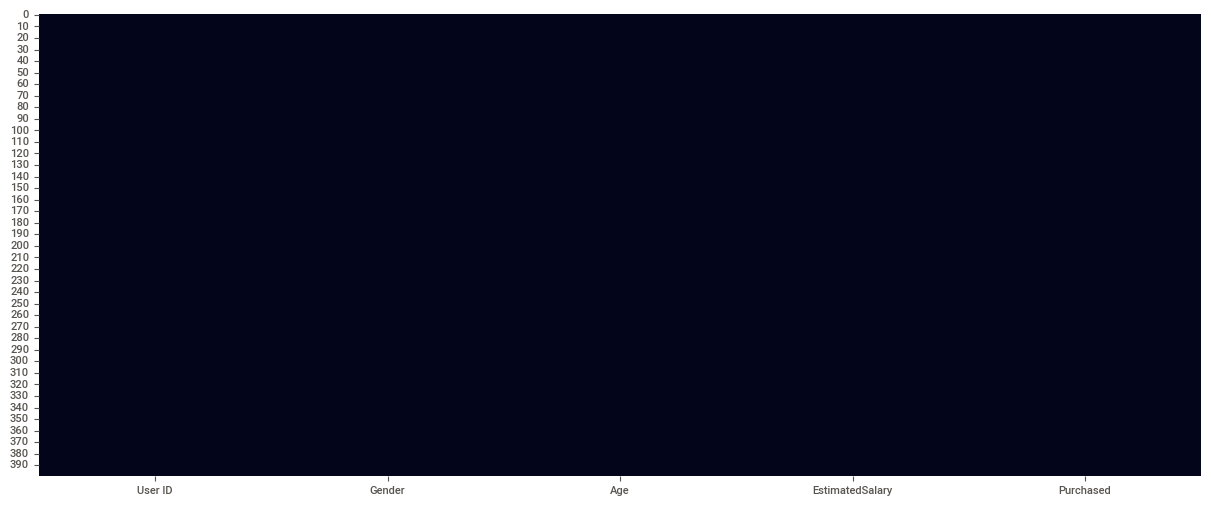

In [274]:
plt.figure(figsize=(15,6))
sns.heatmap(df.isna(), cbar=False)
plt.show()

In [275]:
agg_stats = pd.concat([
    df.describe(include='all'), 
    df.select_dtypes(include=np.number).var().to_frame(name='variance').T,
    100 * (df.select_dtypes(include=np.number).std() / df.select_dtypes(include=np.number).mean()).to_frame(name='Coefficient of Variation').T, 
    df.dtypes.to_frame(name='dtype').T,
    df.nunique().to_frame(name='#unique values').T,
    df.isna().sum().to_frame(name='#NaN').T        
]).T.fillna('')

agg_stats

count unique     top freq           mean           std  \
User ID          400.0                      15691539.7575  71658.321581   
Gender             400      2  Female  204                                
Age              400.0                             37.655     10.482877   
EstimatedSalary  400.0                            69742.5  34096.960282   
Purchased        400.0                             0.3575      0.479864   

                        min          25%         50%         75%         max  \
User ID          15566689.0  15626763.75  15694341.5  15750363.0  15815236.0   
Gender                                                                         
Age                    18.0        29.75        37.0        46.0        60.0   
EstimatedSalary     15000.0      43000.0     70000.0     88000.0    150000.0   
Purchased               0.0          0.0         0.0         1.0         1.0   

                          variance Coefficient of Variation   dtype  \
User ID          5134915051.833278                 0.456669   int64   
Gender                                                       object   
Age                     109.890702                27.839269   int64   
EstimatedSalary  1162602700.501253                48.889788   int64   
Purchased                 0.230269               134.227682   int64   

                #unique values #NaN  
User ID                    400    0  
Gender                       2    0  
Age                         43    0  
EstimatedSalary            117    0  
Purchased                    2    0

                                             |          | [  0%]   00:00 -> (? left)


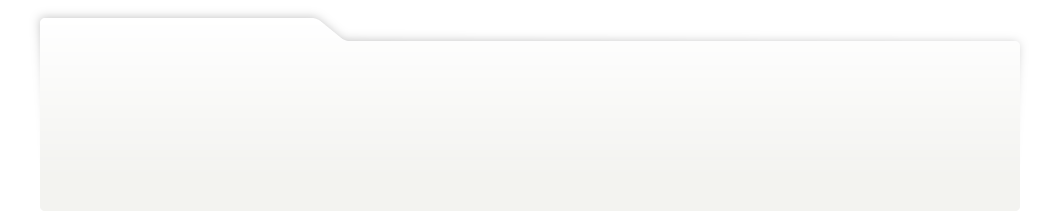
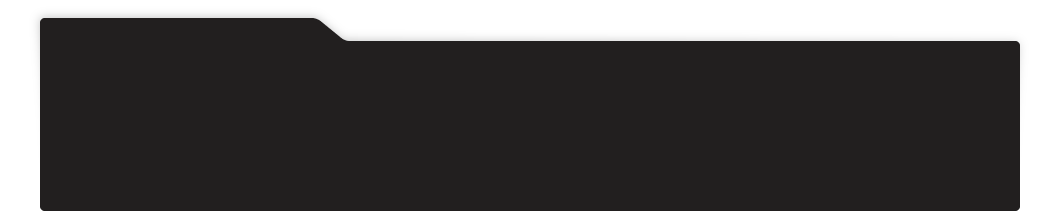
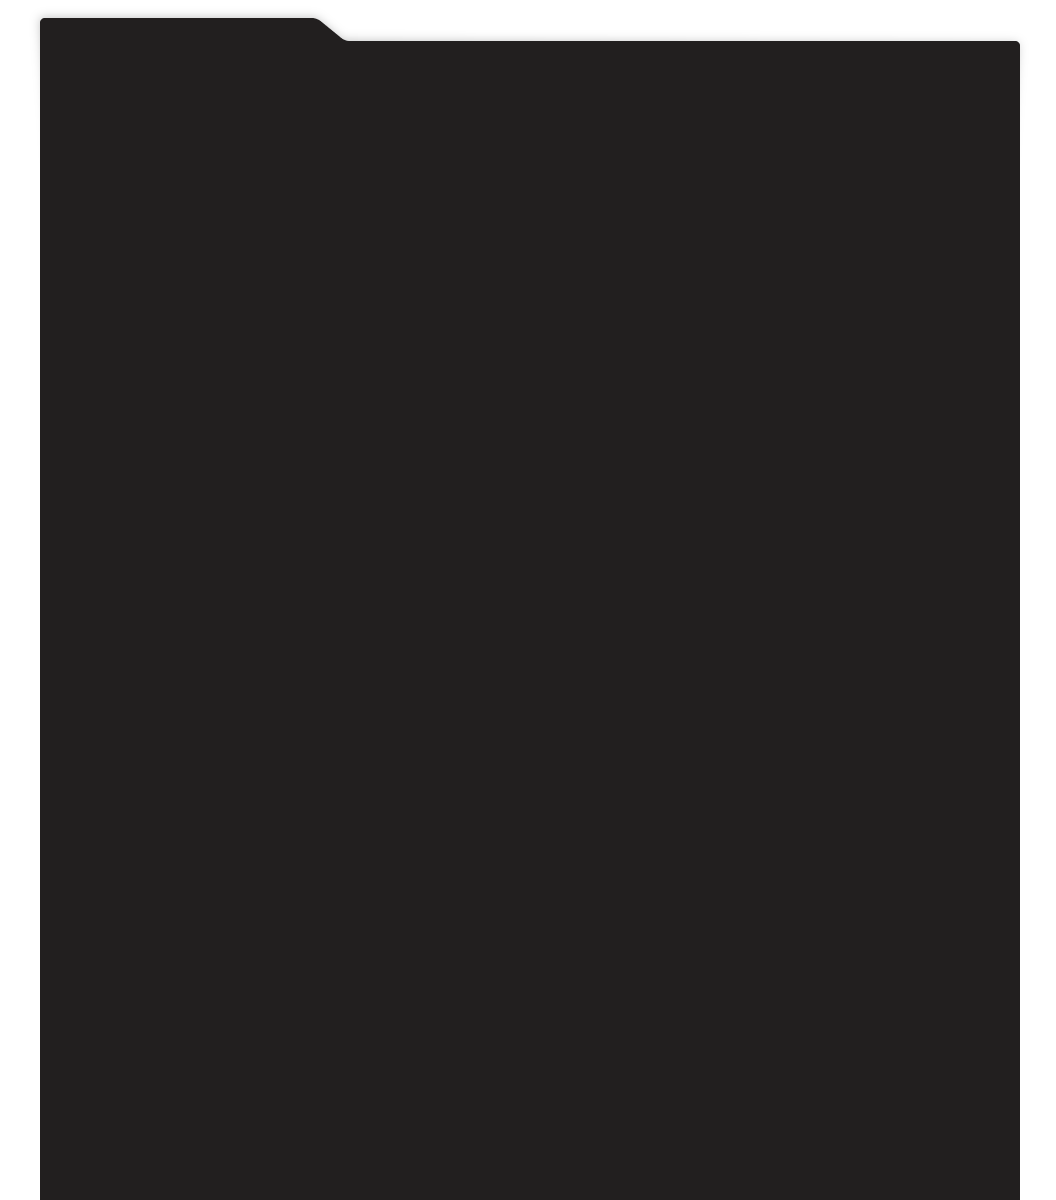
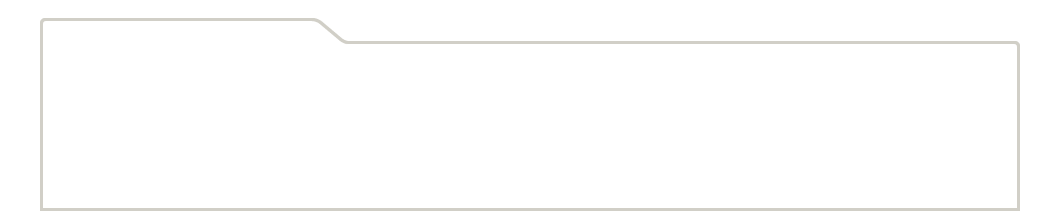
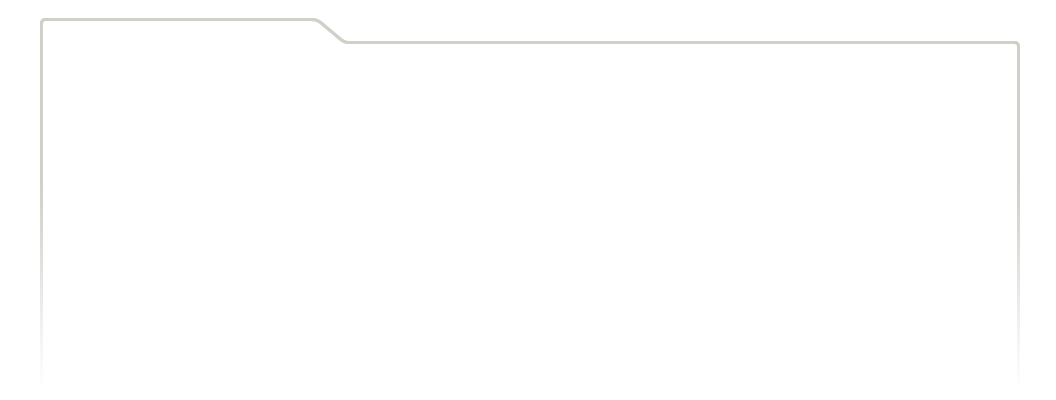
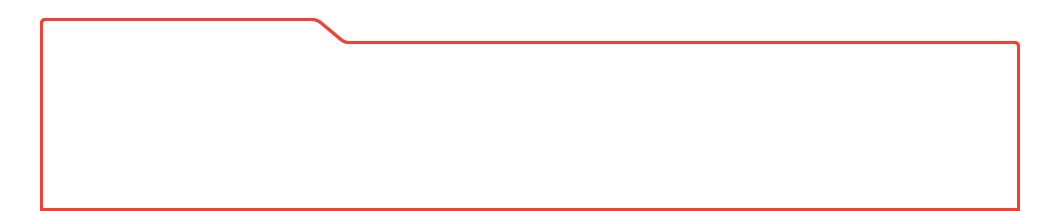
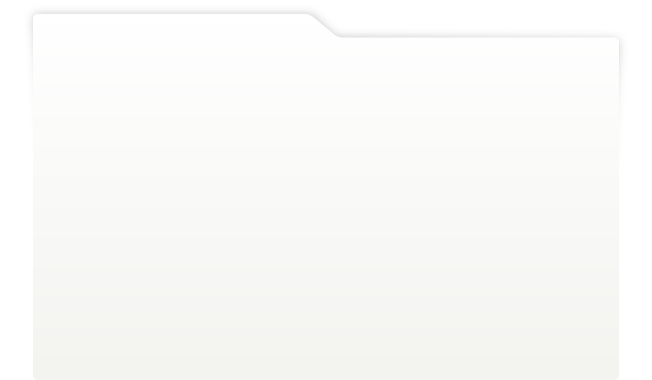
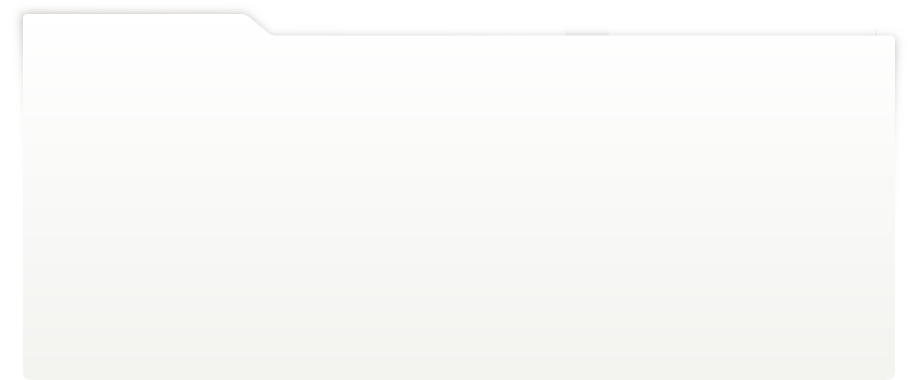
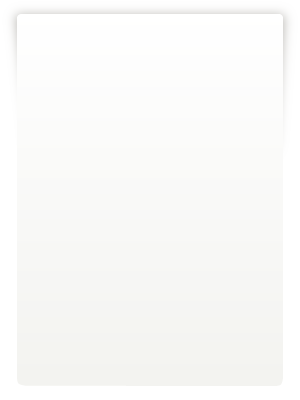
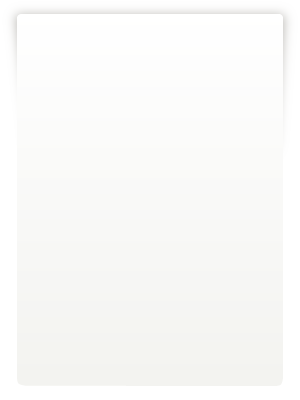
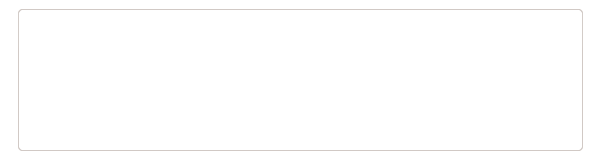
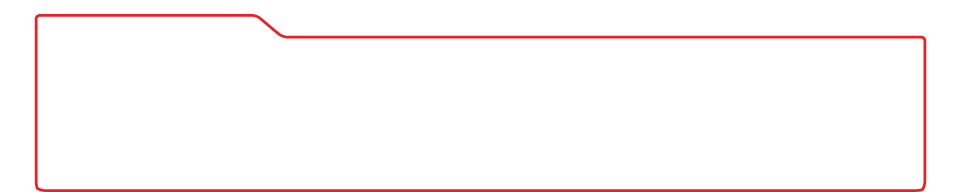
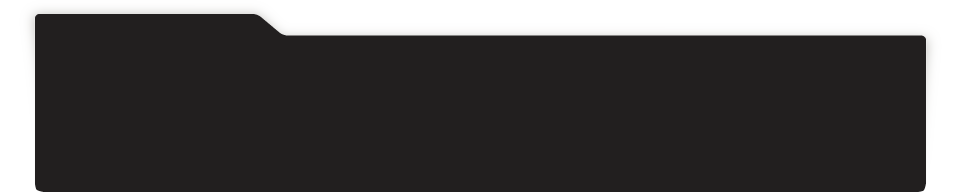
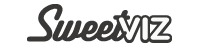
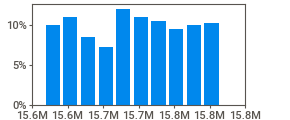
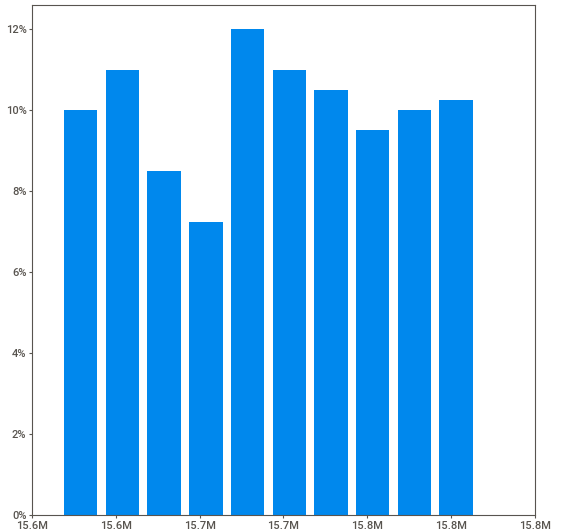
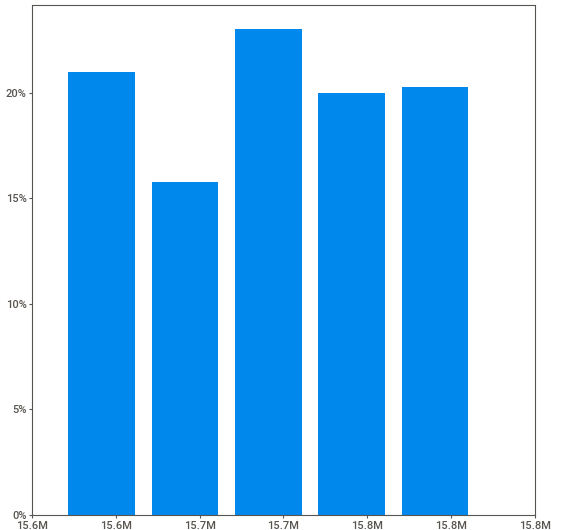
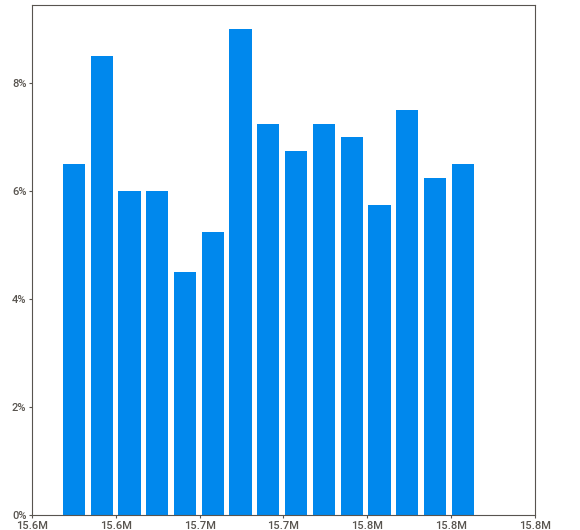
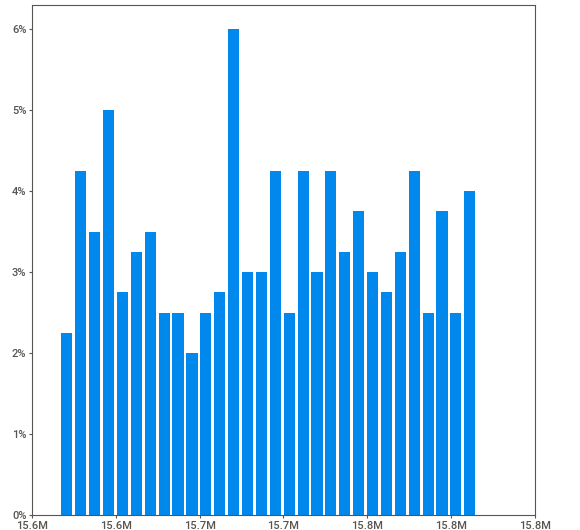
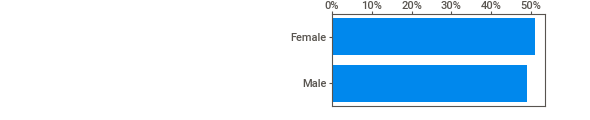
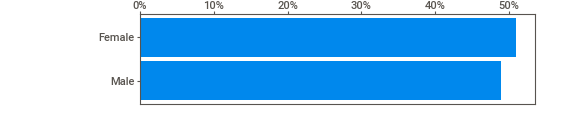
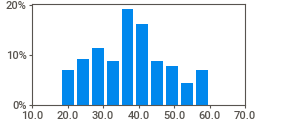
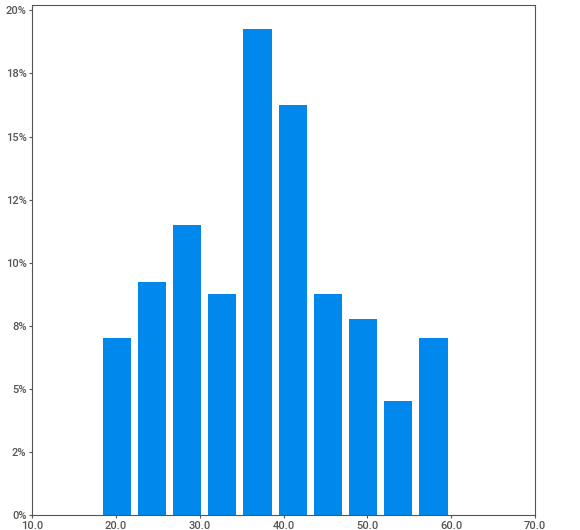
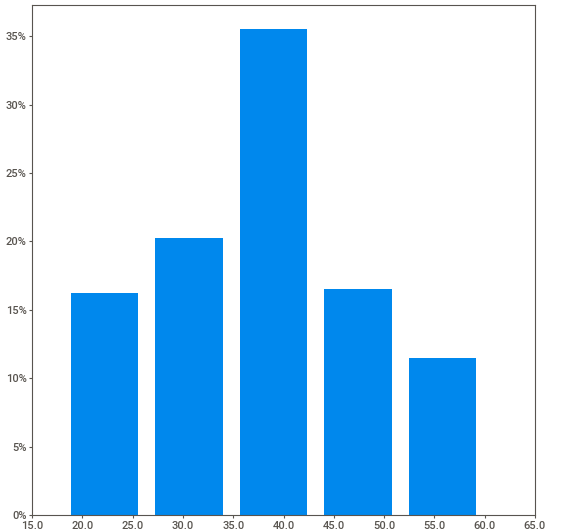
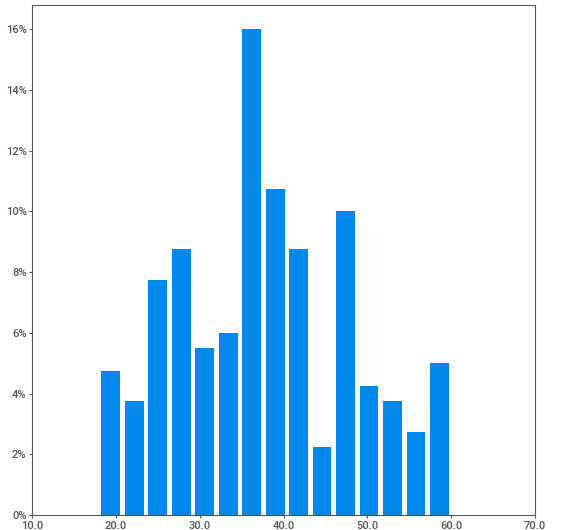
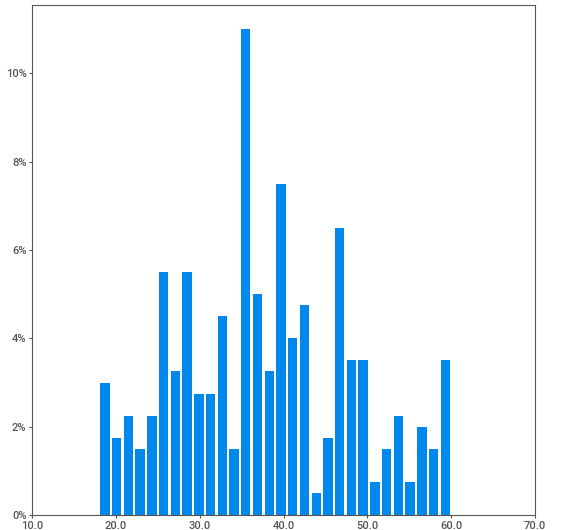
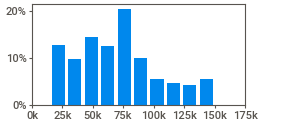
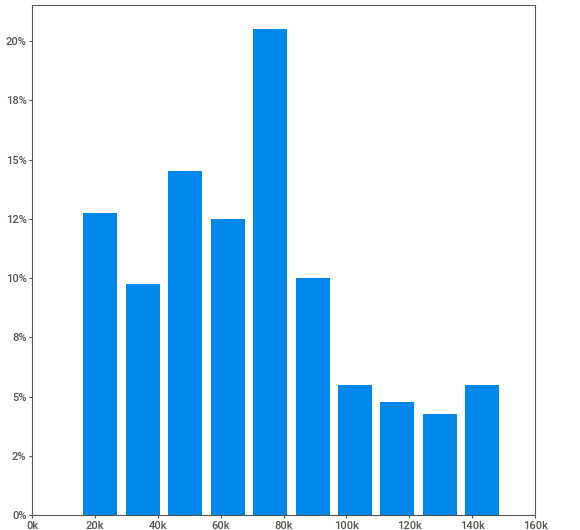
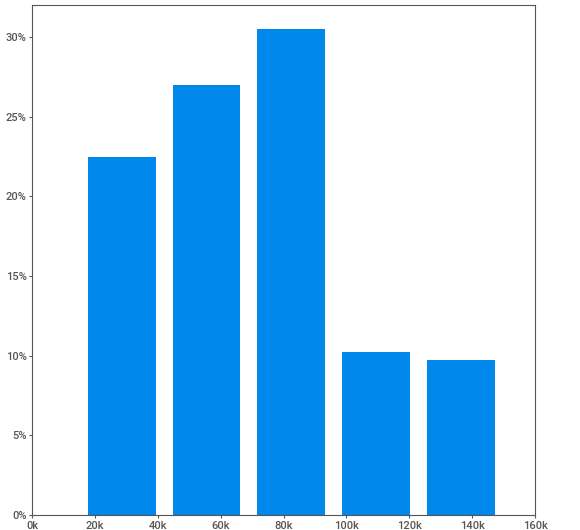
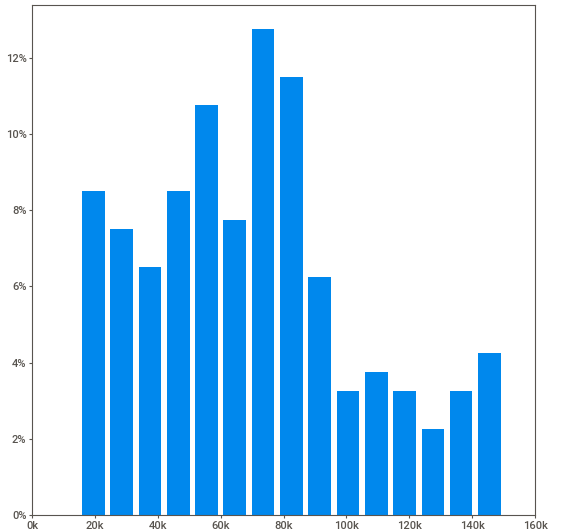
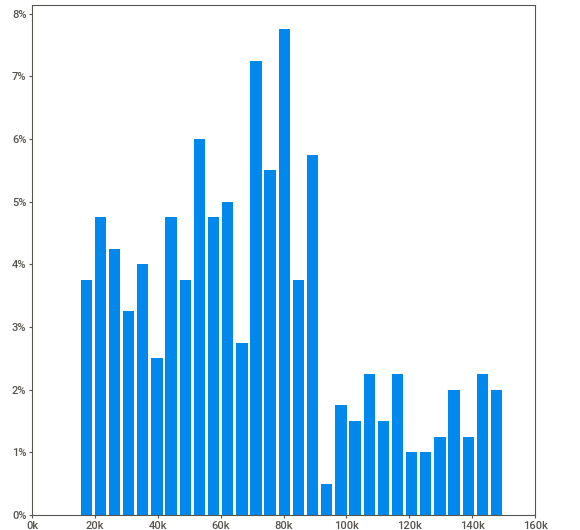
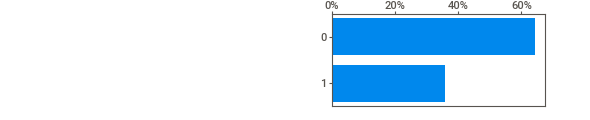
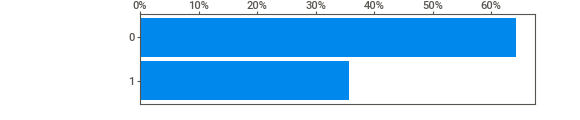
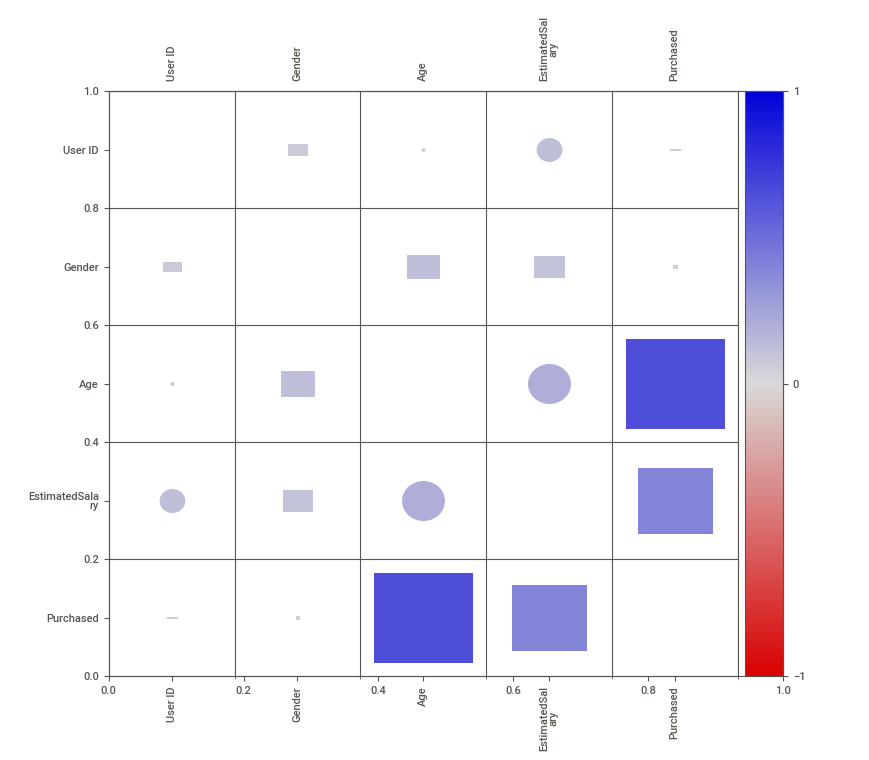
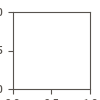

In [276]:
# EDA: Sweetviz library to summarize main characteristics of the dataset
report = sv.analyze(df)
report.show_notebook(layout="vertical", w=880, h=500, scale=0.8)

In [277]:
# Drop 'User ID' column from the DataFrame
df = df.drop(columns=['User ID'])

# Encoding
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
df.head()

Gender  Age  EstimatedSalary  Purchased
0       0   19            19000          0
1       0   35            20000          0
2       1   26            43000          0
3       1   27            57000          0
4       0   19            76000          0

<Figure size 1000x300 with 0 Axes>

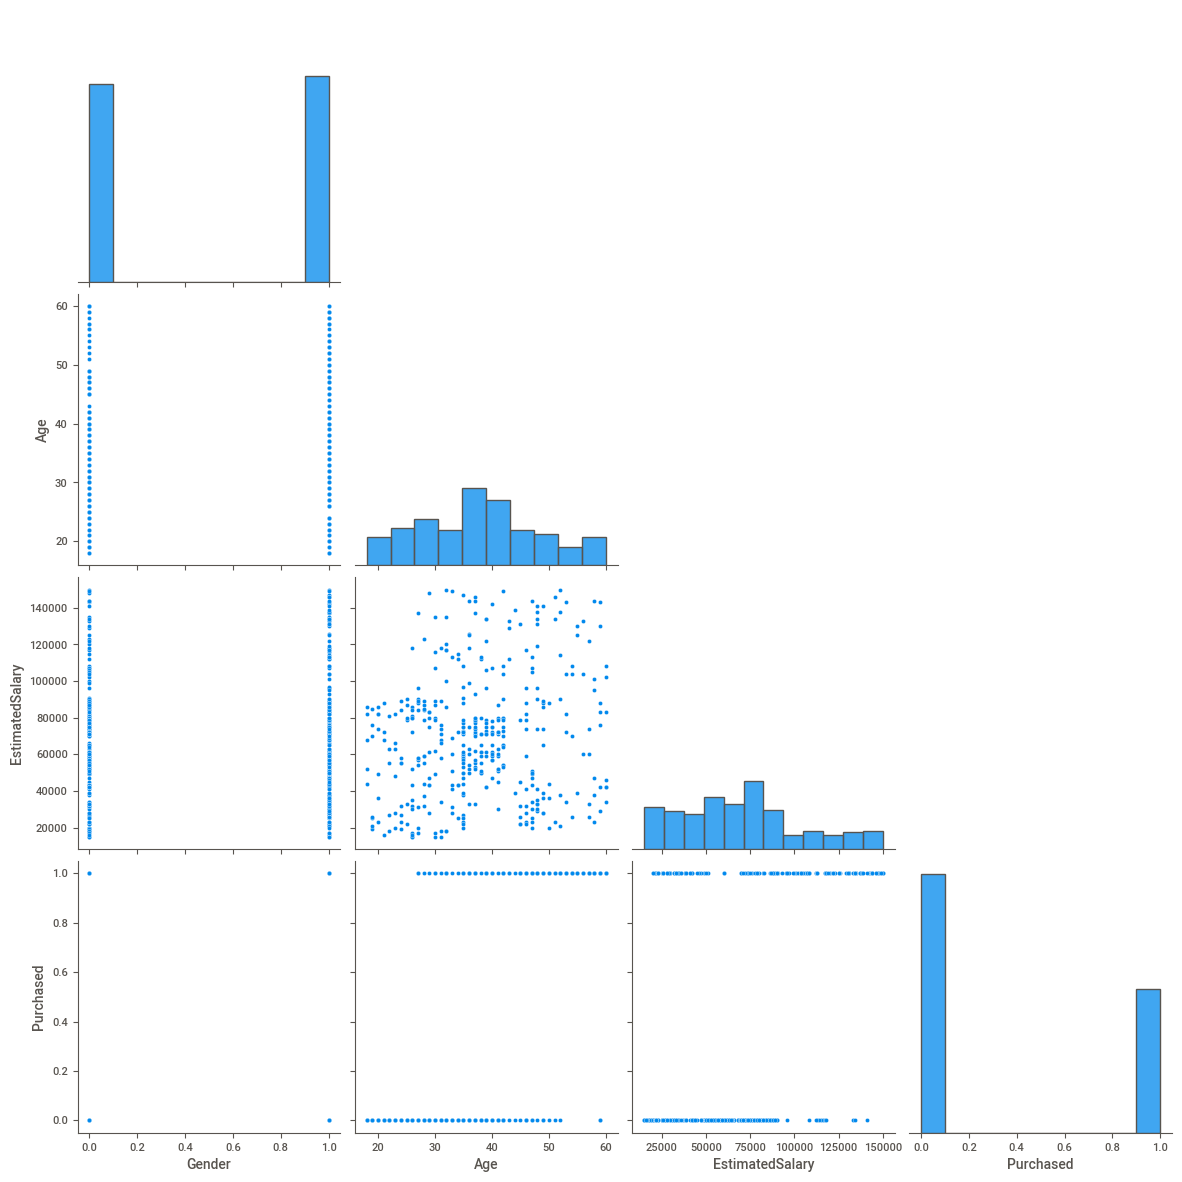

In [278]:
plt.figure(figsize=(10, 3))
sns.pairplot(data=df, height=3, corner=True)
plt.show()

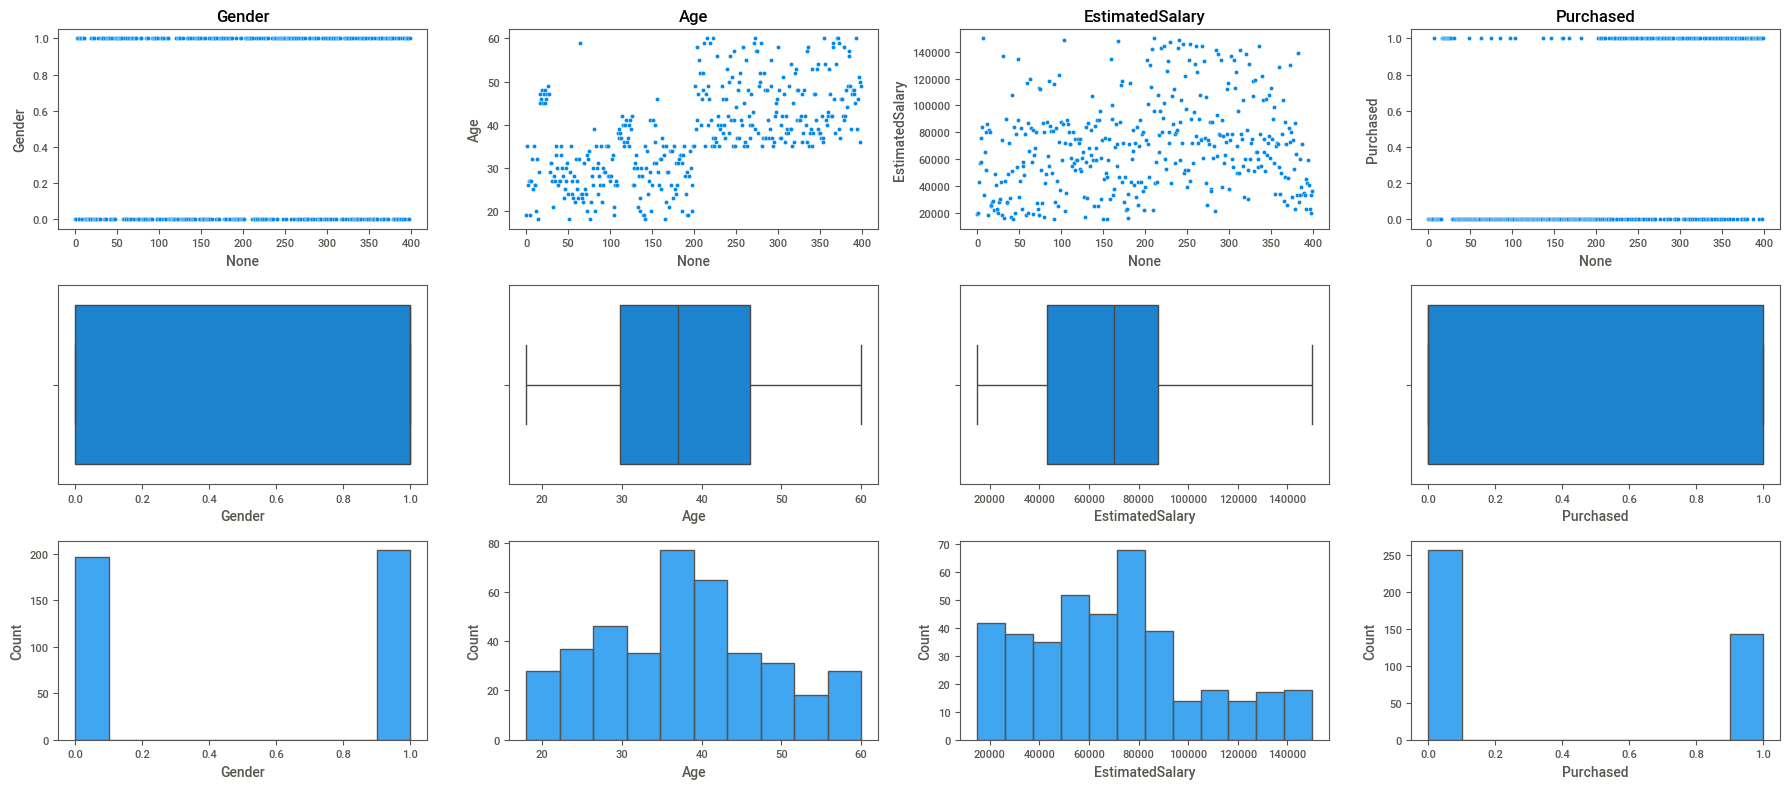

In [279]:
fig, axes = plt.subplots(3, len(df.columns), figsize=(18, 8))

for i, c in enumerate(df.columns):
    sns.scatterplot(data=df, x=df.index, y=df[c], ax=axes[0, i])    
    sns.boxplot(data=df, x=df[c], ax=axes[1, i]) 
    sns.histplot(data=df, x=df[c], ax=axes[2, i]) 
    axes[0, i].set_title(f"{c}")
plt.tight_layout()
plt.show()

Proportion of Female/Male :
 Gender
1    0.51
0    0.49
Name: proportion, dtype: float64


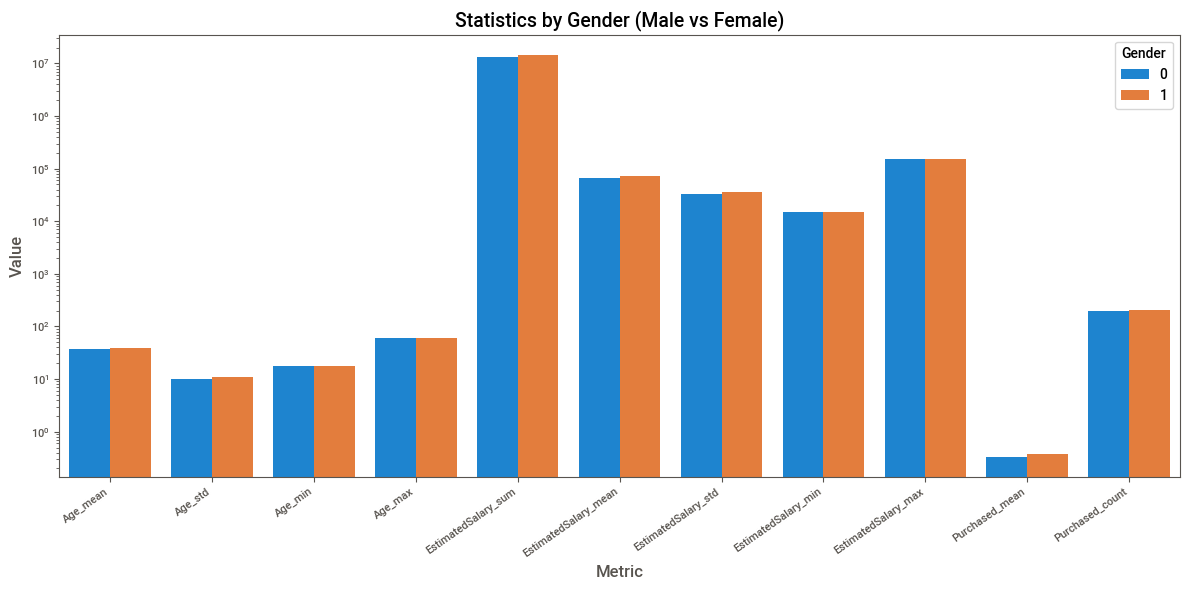

In [280]:
# Proportion of Male and Female
print('Proportion of Female/Male :\n', df['Gender'].value_counts(normalize=True))

# Aggregate statistics by Gender
stats = df.groupby('Gender').agg({
    'Age': ['mean', 'std', 'min', 'max'],
    'EstimatedSalary': ['sum', 'mean', 'std', 'min', 'max'],
    'Purchased': ['mean', 'count']
})

# Flatten multi-level columns and reset index for easier plotting
stats.columns = ['_'.join(col).strip() for col in stats.columns] 
stats.reset_index(inplace=True)

# Melt the DataFrame to make it long-form for easier plotting
stats_melted = stats.melt(id_vars=['Gender'], var_name='Metric', 
    value_name='Value', value_vars=[c for c in stats.columns if c != 'Gender'])

plt.figure(figsize=(12, 6))
sns.barplot(data=stats_melted, x='Metric', y='Value', hue='Gender')
plt.title('Statistics by Gender (Male vs Female)', fontsize=14)
plt.xlabel('Metric', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.yscale('log')  # Use logarithmic scale for better visibility
plt.xticks(rotation=35, ha='right')
plt.tight_layout()
plt.show()

In [281]:
X = df.drop(['Purchased'], axis=1) 
y = df['Purchased'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Scaling

We standardize data:
- to reduce the gap between the different scales of variables
- This is essential if the model is to give a fair weight to each variable during classification

In [282]:
scaler = StandardScaler()
X_train[X_train.select_dtypes('number').columns] = scaler.fit_transform(X_train.select_dtypes('number'))
X_test[X_test.select_dtypes('number').columns] = scaler.transform(X_test.select_dtypes('number'))

# Modeling

We train models using different criteria (entropy, gini, log_loss):
- entropy: Uses information gain to decide splits
- gini: Uses the Gini impurity metric for splits
- log_loss: Uses log loss for classification tasks with probabilities


In [283]:
models = {'entropy model': None,'gini model': None, 'log_loss model': None}

for k in models.keys():
    crit = k.split()[0]
    classifier = DecisionTreeClassifier(criterion=crit, random_state=42)
    classifier.fit(X_train, y_train)
    models[k] = classifier

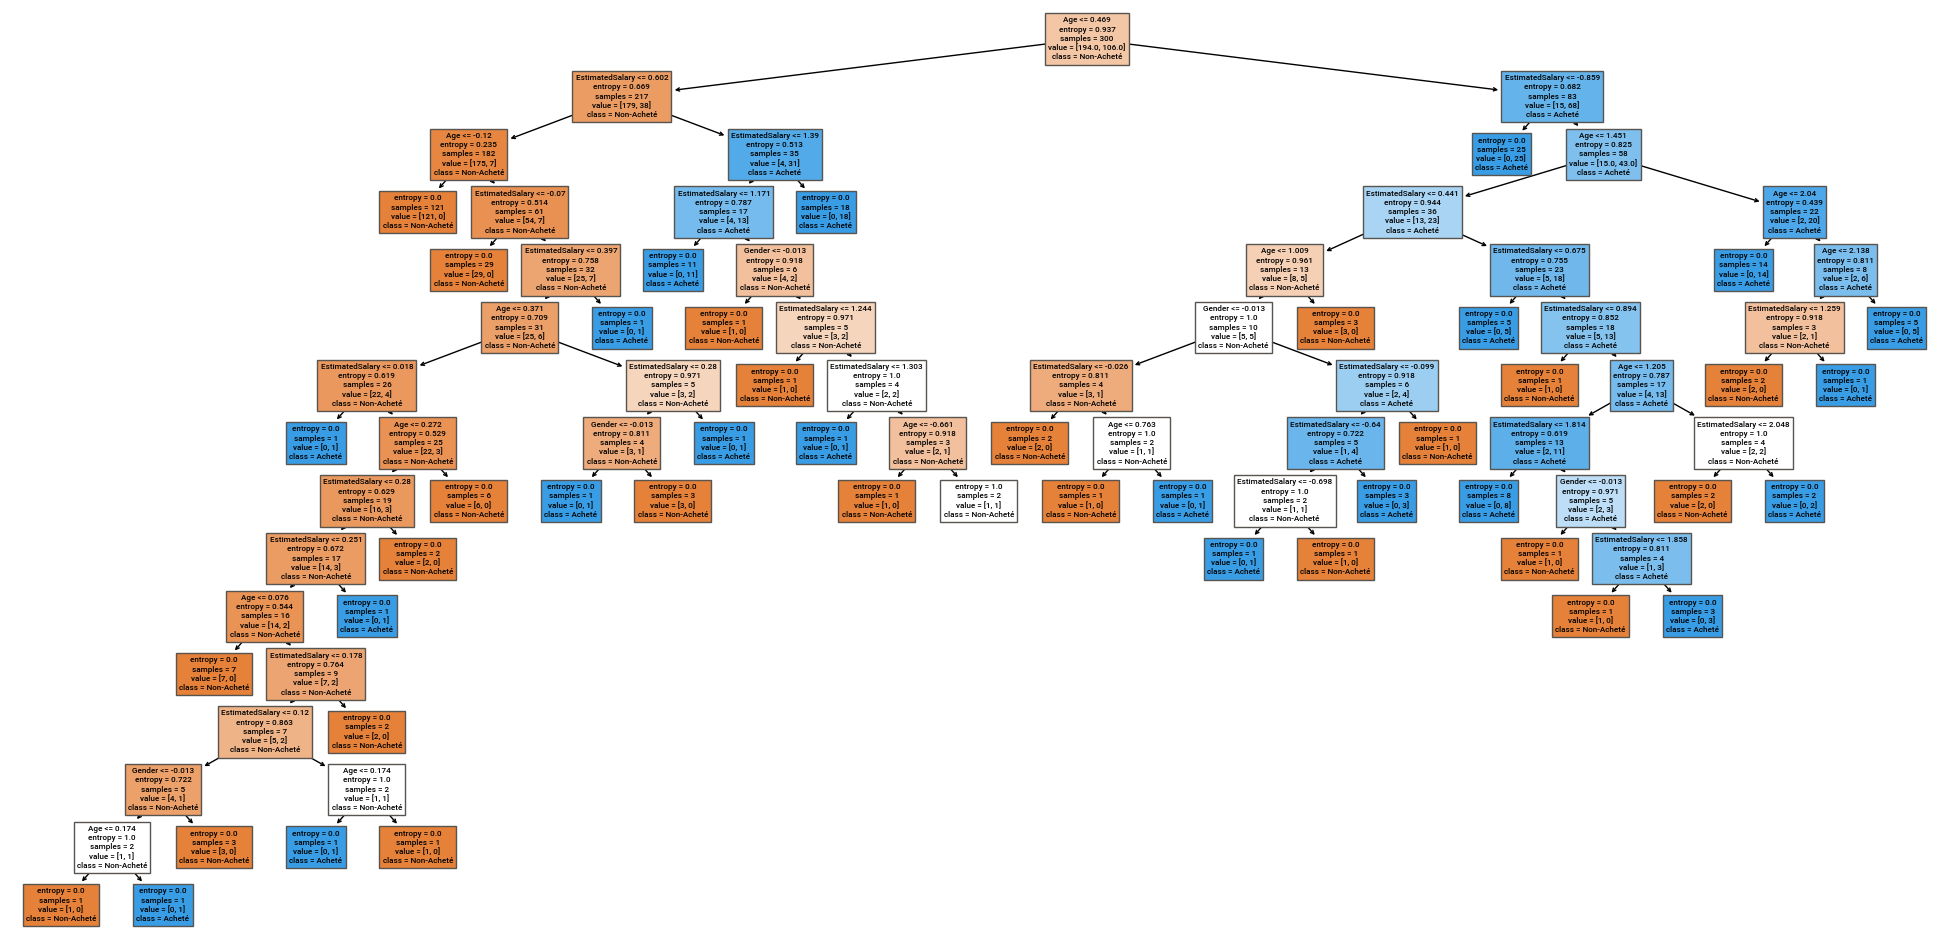

In [284]:
i = 0
plt.figure(figsize=(25, 12))
tree.plot_tree(list(models.values())[i], feature_names=X_train.columns, class_names=['Non-Acheté', 'Acheté'], filled=True)
plt.show()

### Depth & Number of Leaves

Depth of the tree indicates the maximum number of splits from the root node to the deepest leaf node
- A larger depth can capture more complex patterns but risks overfitting

Number of Leaves represents the number of terminal nodes:
- Are the endpoints of the decision paths
- Each leaf corresponds to a subset of the training data with a unique predicted output



These results indicate that:
- the models differ slightly in their complexity (depth)
- but all have the same number of leaves, which could imply that they are similarly structured in terms of how the data is split

In [285]:
data = []
for name, model in models.items():
    depth = model.get_depth()
    n_leaves = model.get_n_leaves()
    data.append({'Model': name, 'Depth': depth, 'Number of Leaves': n_leaves})

pd.DataFrame(data)


Model  Depth  Number of Leaves
0   entropy model     15                45
1      gini model     14                45
2  log_loss model     15                45

### Importance of Features

Indicating the importance of each feature in making predictions:
- Higher scores indicate more important features

<br>

Overall, the models emphasize `EstimatedSalary` and `Age` as key features, with `Gender` being largely irrelevant in terms of feature importance
- The small differences in importance values across the 3 models indicate that the features relevance,is stable across different criteria used 

In [286]:
data = []
for name, model in models.items():
    importances = model.feature_importances_
    features = pd.DataFrame({'Features' : X_train.columns, 'Importance' : importances})
    features['Model'] = name
    features = features.sort_values(by='Importance', ascending=False)
    data.append(features)

importance_df = pd.concat(data, ignore_index=True)
importance_df

Features  Importance           Model
0  EstimatedSalary    0.552489   entropy model
1              Age    0.417542   entropy model
2           Gender    0.029969   entropy model
3  EstimatedSalary    0.507322      gini model
4              Age    0.457679      gini model
5           Gender    0.035000      gini model
6  EstimatedSalary    0.552489  log_loss model
7              Age    0.417542  log_loss model
8           Gender    0.029969  log_loss model

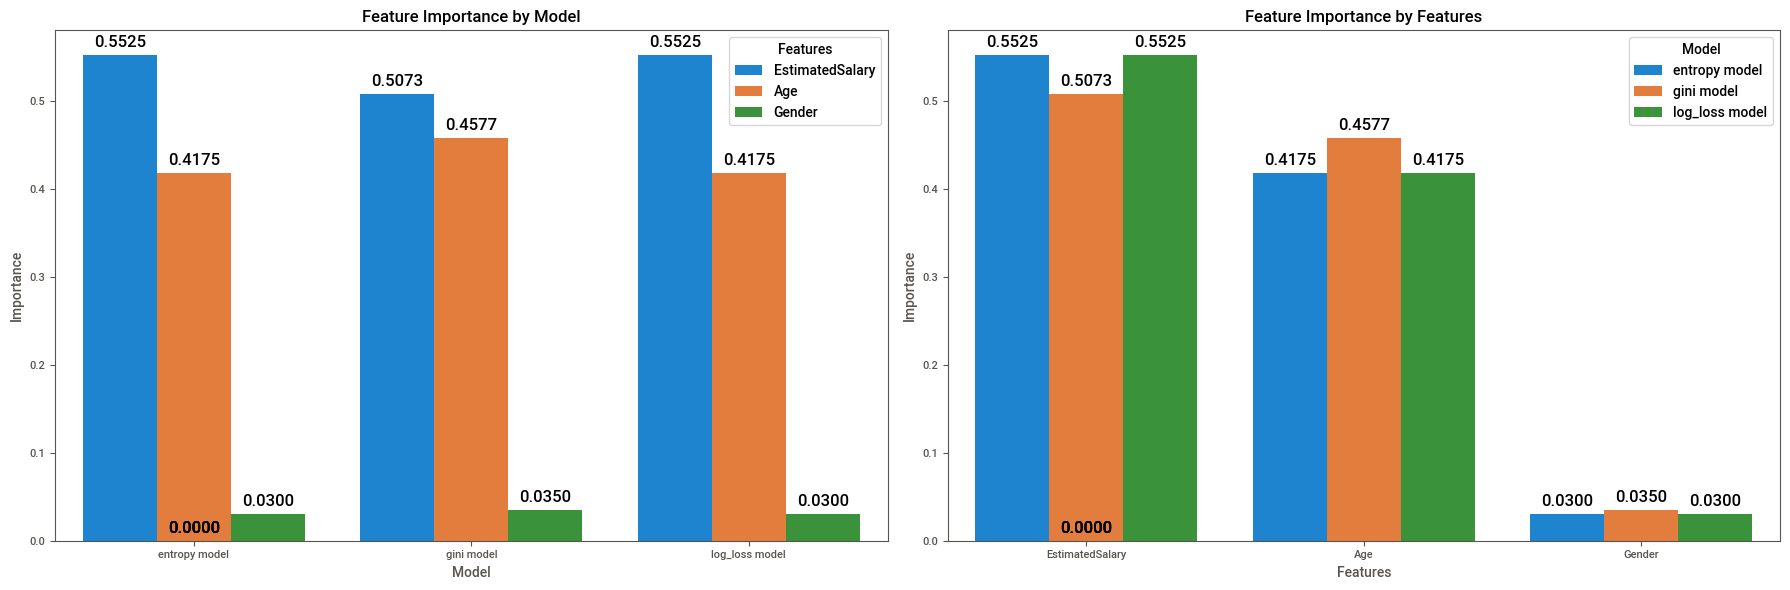

In [287]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
sns.barplot(data=importance_df, x='Model', y='Importance', hue='Features', ax=axs[0])
axs[0].set_title('Feature Importance by Model')
sns.barplot(data=importance_df, x='Features', y='Importance', hue='Model', ax=axs[1])
axs[1].set_title('Feature Importance by Features')

for ax in axs:
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width()/2., p.get_height()), 
                    ha='center', va='center', fontsize=12, xytext=(0, 9), textcoords='offset points')
plt.tight_layout()
plt.show()

## Performance Assessment

### Confusion Matrix

**Positive/Negative**:  model predicts prodictive/negative class

**True/False**: model predictions match/mismatch real classes 

- True Positives (TP, top-left): Predicted purchased, actually purchased
- False Positives (FP, top-right): Predicted purchased, but not purchased
- True Negatives (TN, bottom-right): Predicted not purchased, actually not purchased
- False Negatives (FN, bottom-left): Predictions not purchased, but actually purchased

<br>


|                    | **Predicted: (0)** | **Predicted: (1)** |
|--------------------|--------------------------|------------------------------|
| **Actual: (0)**    |        TP                |                 FP           |
| **Actual: (1)**    |          FN              |             TN               |



Confusion Matrix Example :
 [[56  7]
 [ 8 29]]


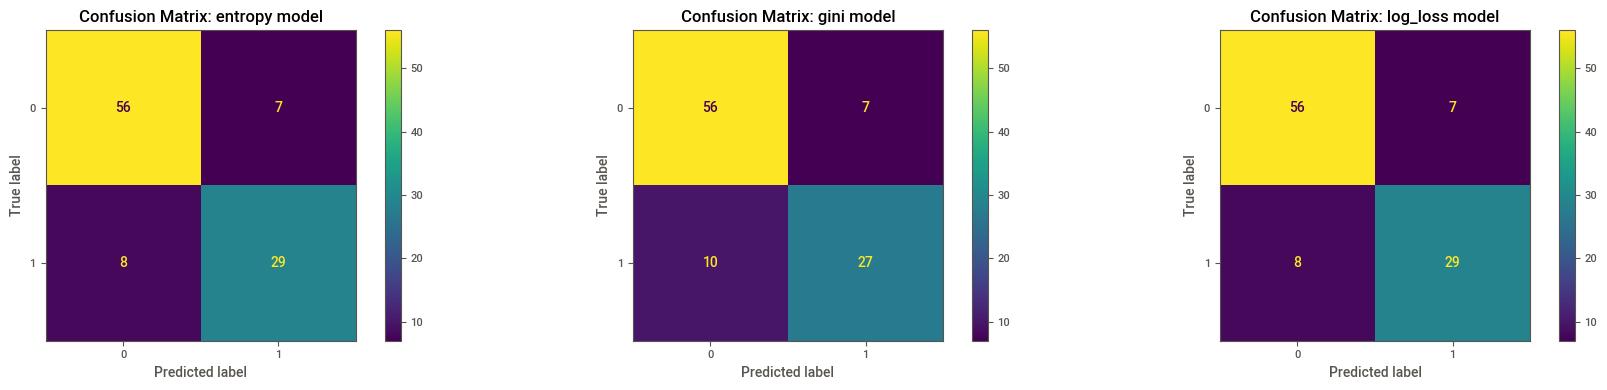

In [288]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
y_preds = dict()
for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    y_preds[name] = y_pred
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=['Non-Acheté', 'Acheté'])
    cm_display.plot(ax=axs[i])
    axs[i].set_title(f'Confusion Matrix: {name}')

print("Confusion Matrix Example :\n", cm)
plt.tight_layout()
plt.show()

### Accuracy, Precision, Recall, F1 Score

For criteria='entropy' for instance:
- Accuracy = %class correctly predicted = TN + TP 
- Precision = %positive predictions that are correct = TP/(TP+FP) 
- Recall = %actual positives that are correctly predicted = TP/(TP+FN) 
- F1 Score = balances precision and recall, providing their harmonic mean = (Precision . Recall) / (Precision + Recall) 

<br>

- Entropy Model and Log Loss Model are the top-performing models in terms of accuracy, precision, recall, and F1 score
- Gini Model underperforms slightly in all metrics, showing it is less effective at classifying positive cases

In [289]:
data = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    data.append([name, accuracy, precision, recall, f1])

score_df = pd.DataFrame(data, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
score_df_melted = score_df.melt(id_vars='Model', value_vars=score_df.columns[1:], var_name='Metric', value_name='Score')
score_df

Model  Accuracy  Precision    Recall  F1 Score
0   entropy model      0.85   0.805556  0.783784  0.794521
1      gini model      0.83   0.794118  0.729730  0.760563
2  log_loss model      0.85   0.805556  0.783784  0.794521

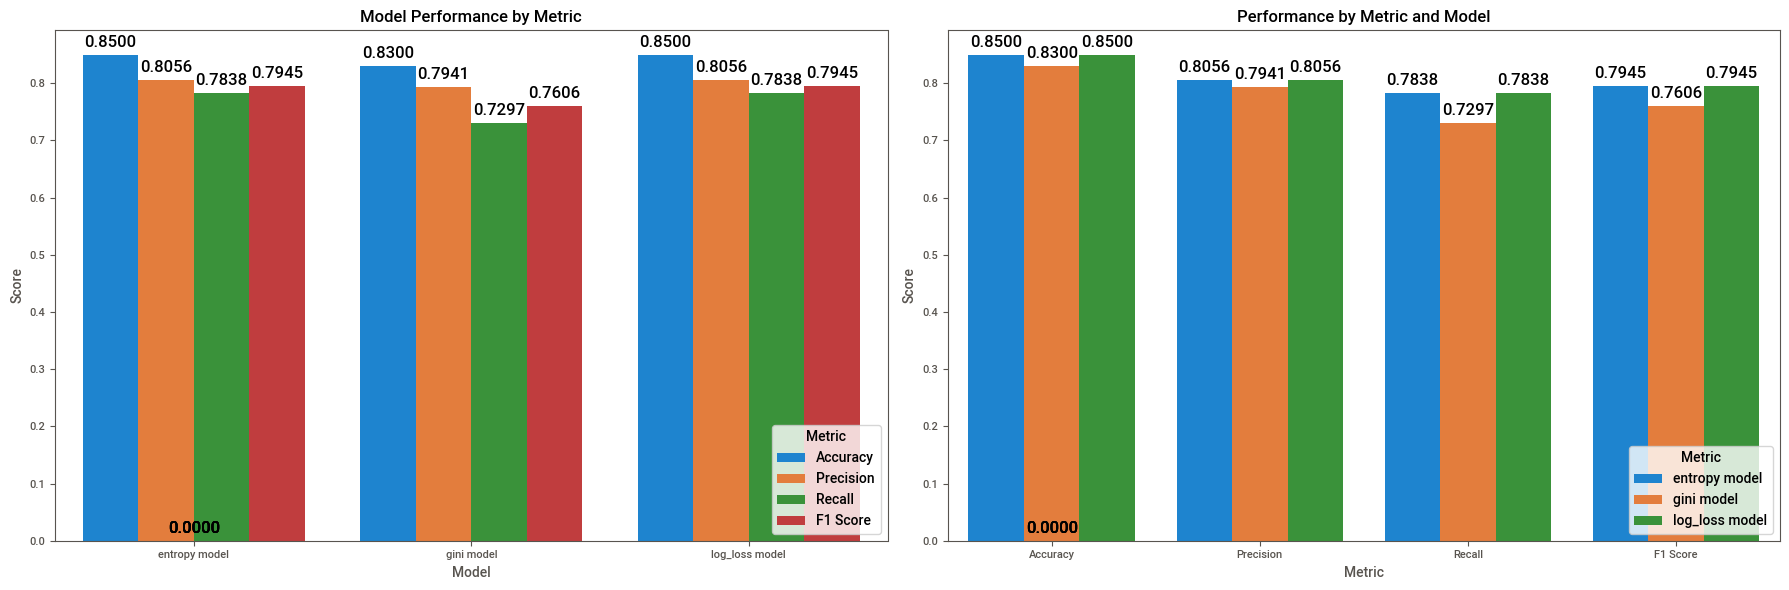

In [290]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
sns.barplot(data=score_df_melted, x='Model', y='Score', hue='Metric', ax=axs[0])
axs[0].set_title('Model Performance by Metric')
axs[0].legend(title='Metric', loc='lower right', bbox_to_anchor=(1, 0))

sns.barplot(data=score_df_melted, x='Metric', y='Score', hue='Model', ax=axs[1])
axs[1].set_title('Performance by Metric and Model')
axs[1].legend(title='Metric', loc='lower right', bbox_to_anchor=(1, 0))

for ax in axs:
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width()/2., p.get_height()), 
                    ha='center', va='center', fontsize=12, xytext=(0, 9), textcoords='offset points')
plt.tight_layout()
plt.show()

### ROC (Receiver Operating Characteristic) Curve

The ROC (Receiver Operating Characteristic) curve is used to evaluate the performance of a classification model:
- An AUC of 1 means that the model is perfect. It correctly classifies all positive and negative examples without error.
- The closer the AUC is to 1, the better the model performs.
- AUC = 0.5 means the model is no better than random, and an AUC below 0.5 means the model is worse than random.

<br>

All 3 models offer solid performance, but:
- entropy and log_loss-based model seem slightly better than the Gini-based model in this case


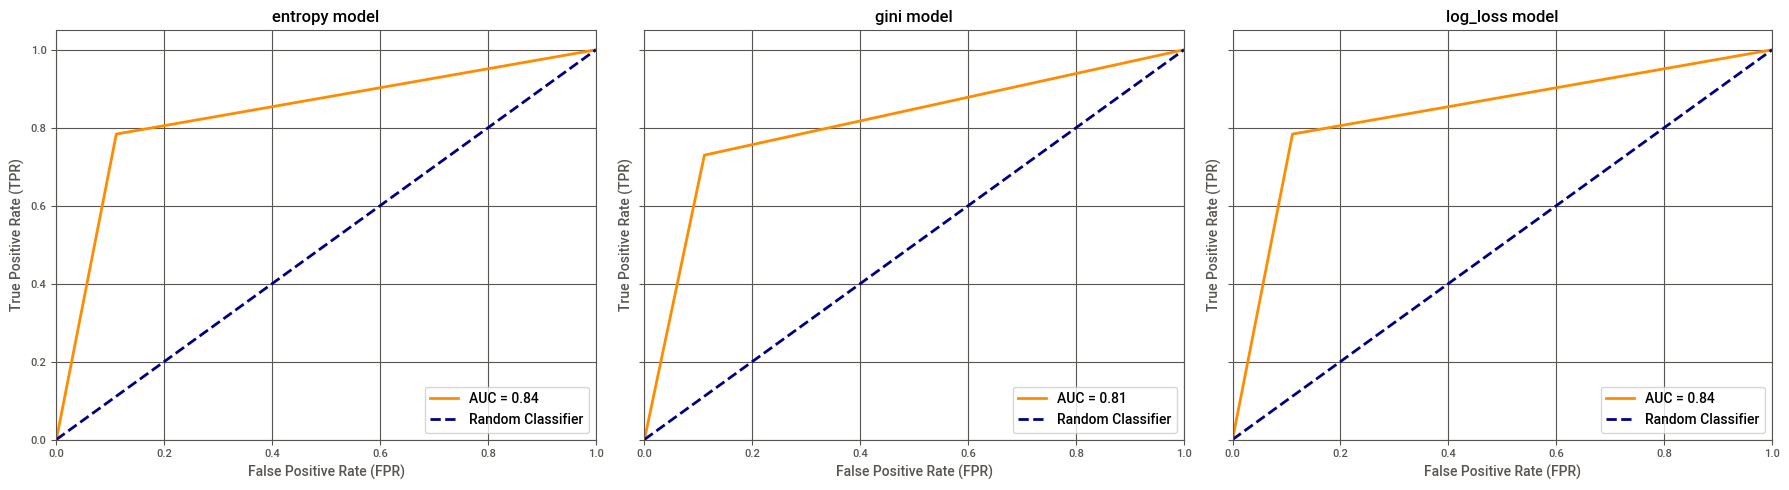

In [291]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)
for ax, (name, model) in zip(axes, models.items()):
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:, 1]
    
    # ROC metrics
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC
    ax.plot(fpr, tpr, lw=2, color='darkorange', label=f'AUC = {roc_auc:.2f}')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate (FPR)')
    ax.set_ylabel('True Positive Rate (TPR)')
    ax.set_title(f'{name}')
    ax.legend(loc="lower right")
    ax.grid()
plt.tight_layout()
plt.show()

## Plot Decision Boundaries

Zones show how the Decision Tree separates classes according to variables
- Failures can occur if real data are non-linear or noisy

In [292]:
def plot_():
    ii, jj = 1, 2  
    cols = list(X_train.iloc[:, [ii, jj]].columns) 
    classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
    classifier.fit(X_train.iloc[:, [ii, jj]], y_train)  

    Xi, Xj = np.meshgrid(np.arange(start=X_train.iloc[:, ii].min(), stop=X_train.iloc[:, ii].max(), step=0.01),
                        np.arange(start=X_train.iloc[:, jj].min(), stop=X_train.iloc[:, jj].max(), step=0.01))

    Xi = X_train.iloc[:, ii]  
    Xj = X_train.iloc[:, jj] 

    # Grid from the meshgrid
    #grid = np.vstack([Xi.ravel(), Xj.ravel()]).T

    disp = DecisionBoundaryDisplay.from_estimator(classifier, X_train.iloc[:, [ii, jj]], response_method="predict",
                    xlabel=cols[0], ylabel=cols[1], alpha=0.5)

    disp.ax_.scatter(Xi, Xj, c=y_train, edgecolor="k")
    plt.show()

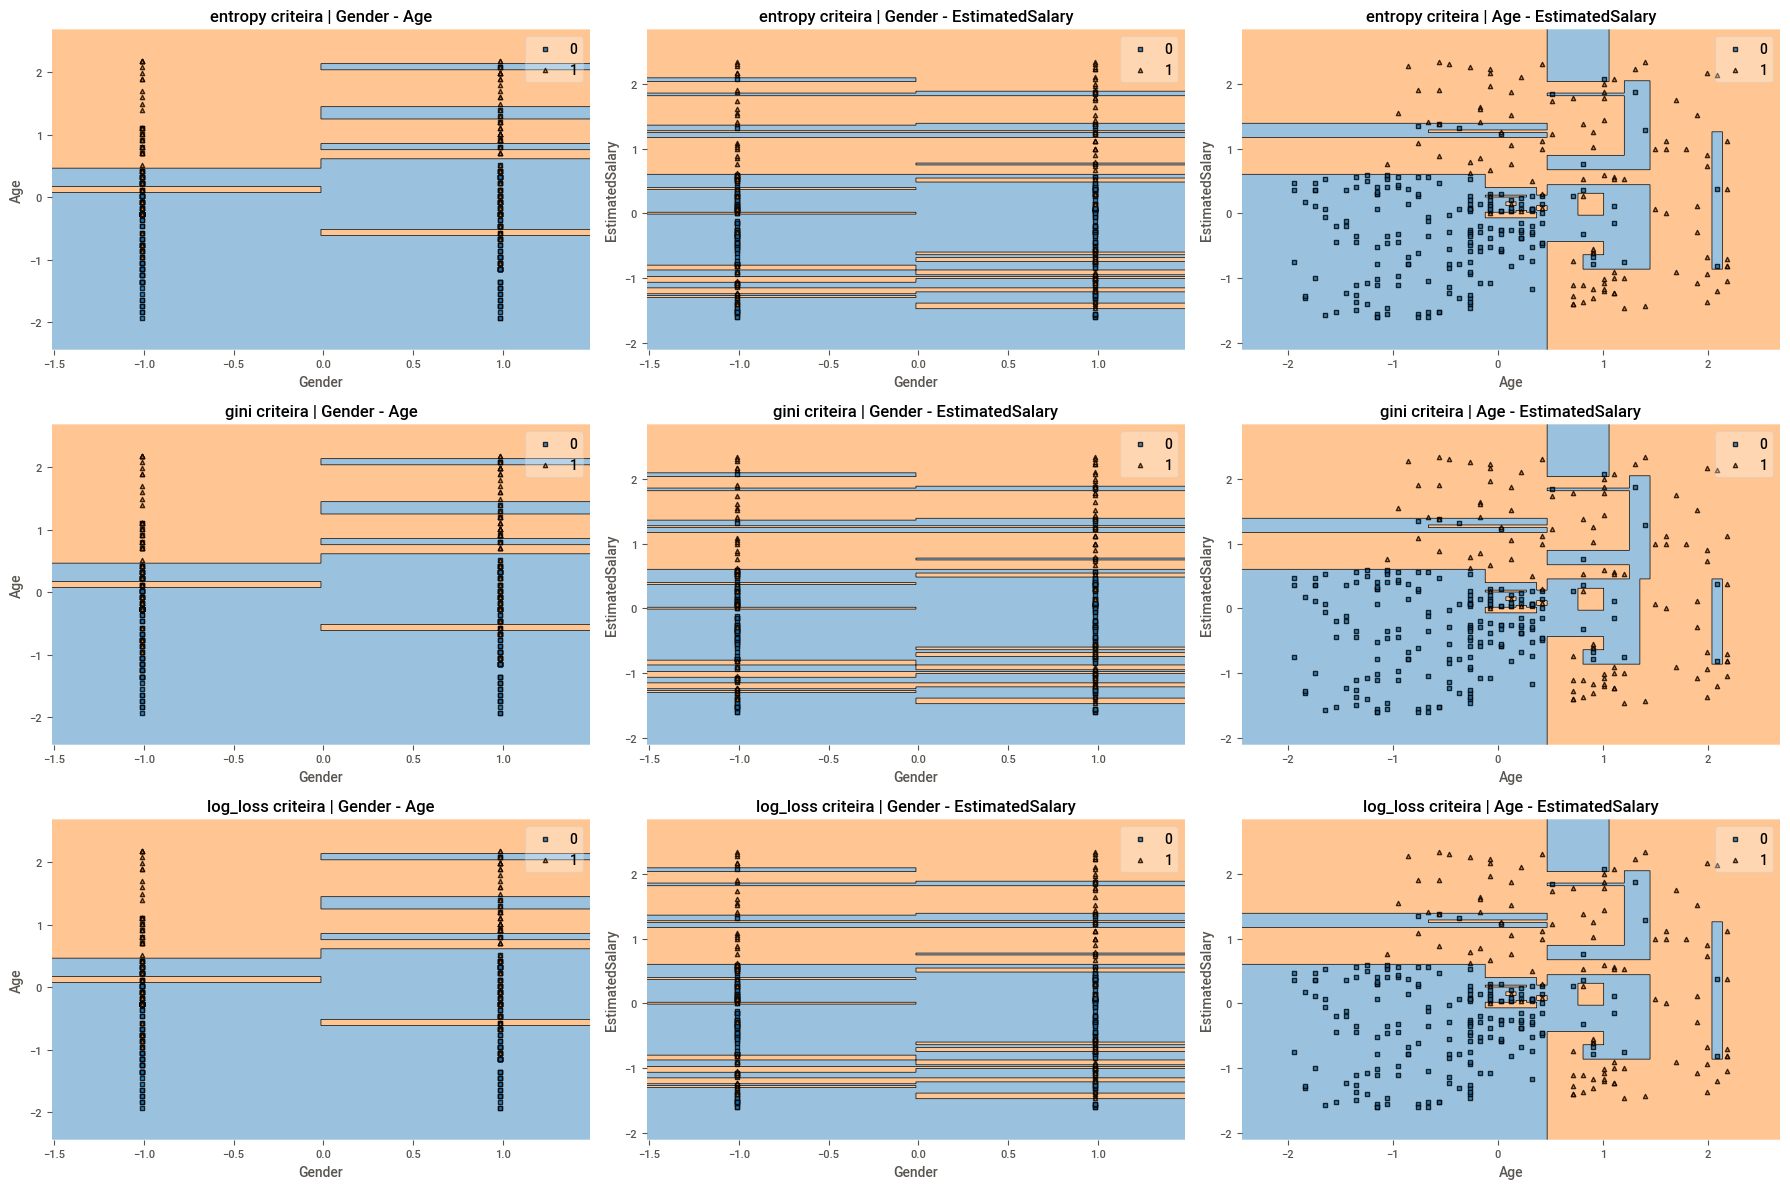

In [293]:
combinations = list(itertools.combinations(range(X_train.shape[1]), 2))
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for i, crit in enumerate(['entropy','gini', 'log_loss']):
    for idx, (ii, jj) in enumerate(combinations):
        ax = axes[idx + i*3]
        cols = X_train.iloc[:, [ii, jj]].columns
        classifier = DecisionTreeClassifier(criterion=crit, random_state=42)
        classifier.fit(X_train[cols], y_train) 

        plot_decision_regions(X_train[cols].values, y_train, clf=classifier, legend=1, #X_highlight=X_test[cols].values
                        zoom_factor=2, ax=ax)
        ax.set_xlabel(cols[0])
        ax.set_ylabel(cols[1])
        ax.set_title(f'{crit} criteira | {cols[0]} - {cols[1]}')
plt.tight_layout()
plt.show()

___

# SVM

SVM Accuracy: 87.00%


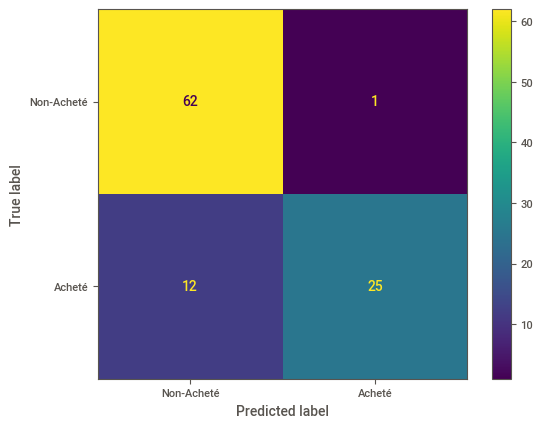

In [294]:
# SVM with linear kernel
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)

# Evaluation
y_svm_pred = svm_classifier.predict(X_test)
svm_cm = confusion_matrix(y_test, y_svm_pred)
svm_accuracy = accuracy_score(y_test, y_svm_pred)
print(f"SVM Accuracy: {svm_accuracy * 100:.2f}%")
ConfusionMatrixDisplay(confusion_matrix=svm_cm, display_labels=['Non-Acheté', 'Acheté']).plot()
plt.show()

____

# Ensemble Learning


| **Method**       | **Training** | **Combination**        | **Strength**                         | **Weakness**                    |
|-------------------|--------------|------------------------|---------------------------------------|----------------------------------|
| Bagging           | Parallel     | Aggregation (average/vote) | Reduces variance, prevents overfitting | May not reduce bias              |
| Random Forest     | Parallel     | Aggregation           | Reduces variance & feature randomness | May struggle with high bias      |
| Boosting          | Sequential   | Weighted combination  | Reduces bias, handles complex patterns | Sensitive to noise, risk of overfitting |
| Stacking          | Sequential     | Meta-model            | Combines diverse model strengths      | Computationally expensive         |



## 1. Bagging

In [295]:
cols = ['Age', 'EstimatedSalary']
bagging = BaggingClassifier(n_estimators=5, estimator=DecisionTreeClassifier(criterion='entropy', random_state=42))
bagging.fit(X_train[cols], y_train)
bagging.score(X_test[cols], y_test)

0.88

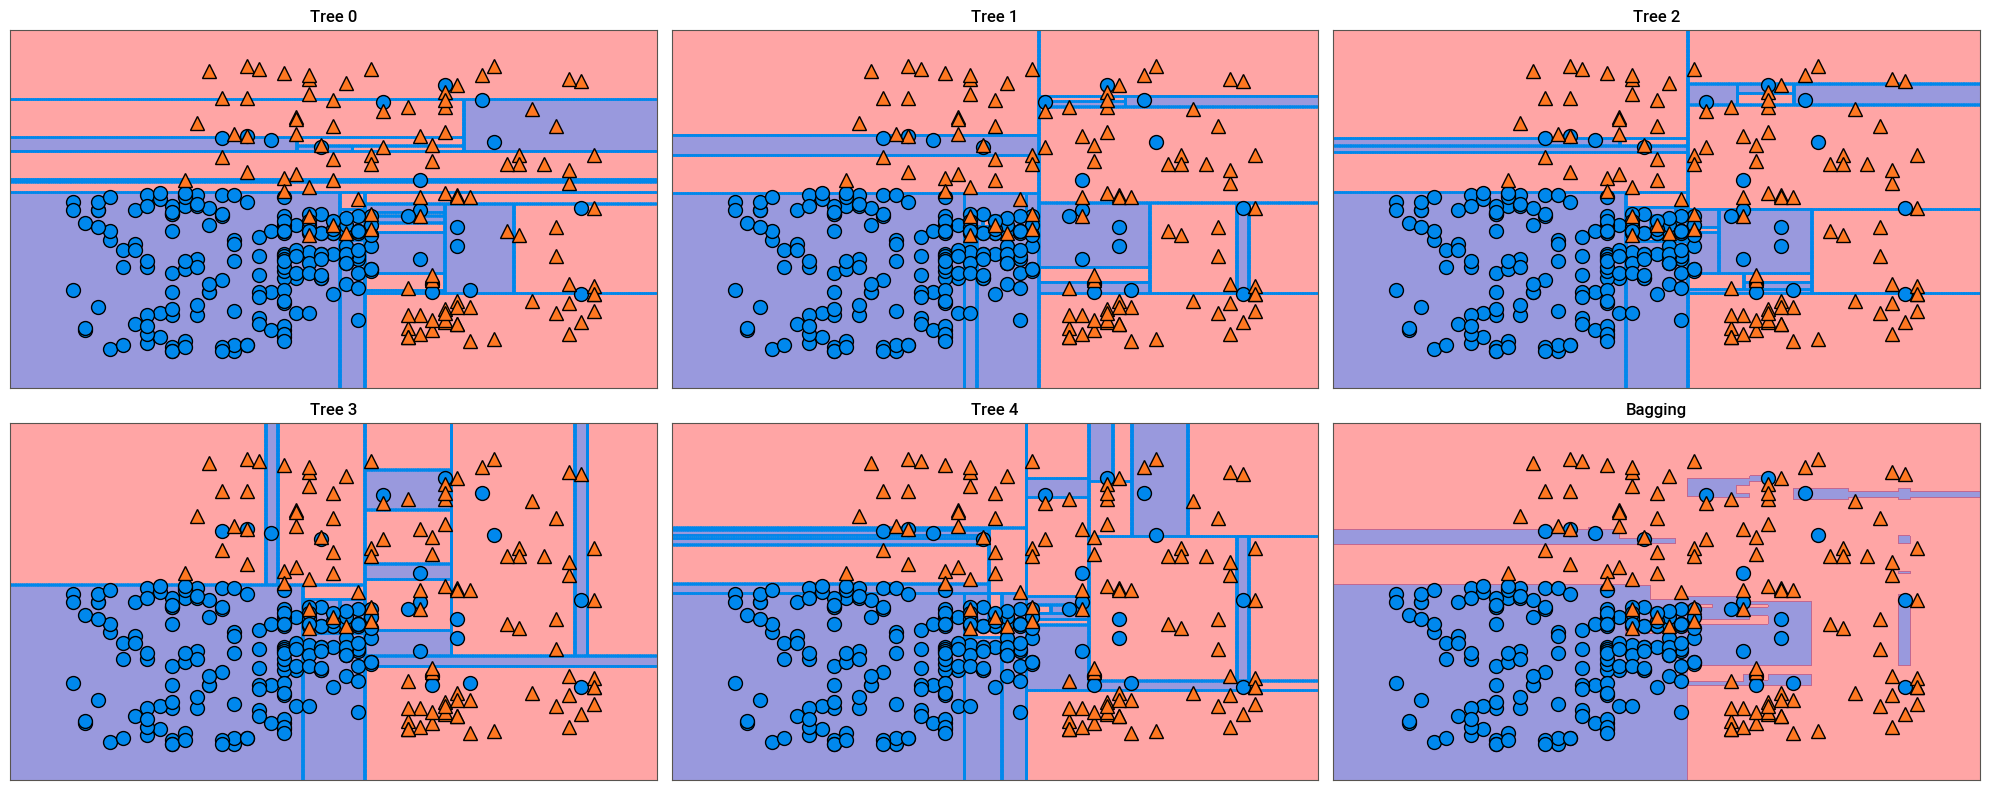

In [296]:
fig, axes = plt.subplots(2, 3, figsize=(20, 8))
Xi = X_train[cols].iloc[:, 0].values
Xj = X_train[cols].iloc[:, 1].values

for i, (ax, tree_) in enumerate(zip(axes.ravel(), bagging.estimators_)):
    ax.set_title("Tree {}".format(i))
    plot_tree_partition(X_train[cols].values, y_train, tree_, ax=ax)
    
plot_2d_separator(bagging, X_train[cols].values, fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title("Bagging")
discrete_scatter(Xi, Xj, y_train)
plt.tight_layout()
plt.show()

## 2. Random Forest 

In [297]:
rfc = RandomForestClassifier(n_estimators=100, oob_score=True, criterion='entropy', random_state=42)
rfc.fit(X_train[cols], y_train)
rfc.score(X_test[cols], y_test)

0.9

In [298]:
select = SelectFromModel(rfc, prefit=True, threshold=0.005)
X_train2 = select.transform(X_train[cols])
print(X_train2.shape)

(300, 2)


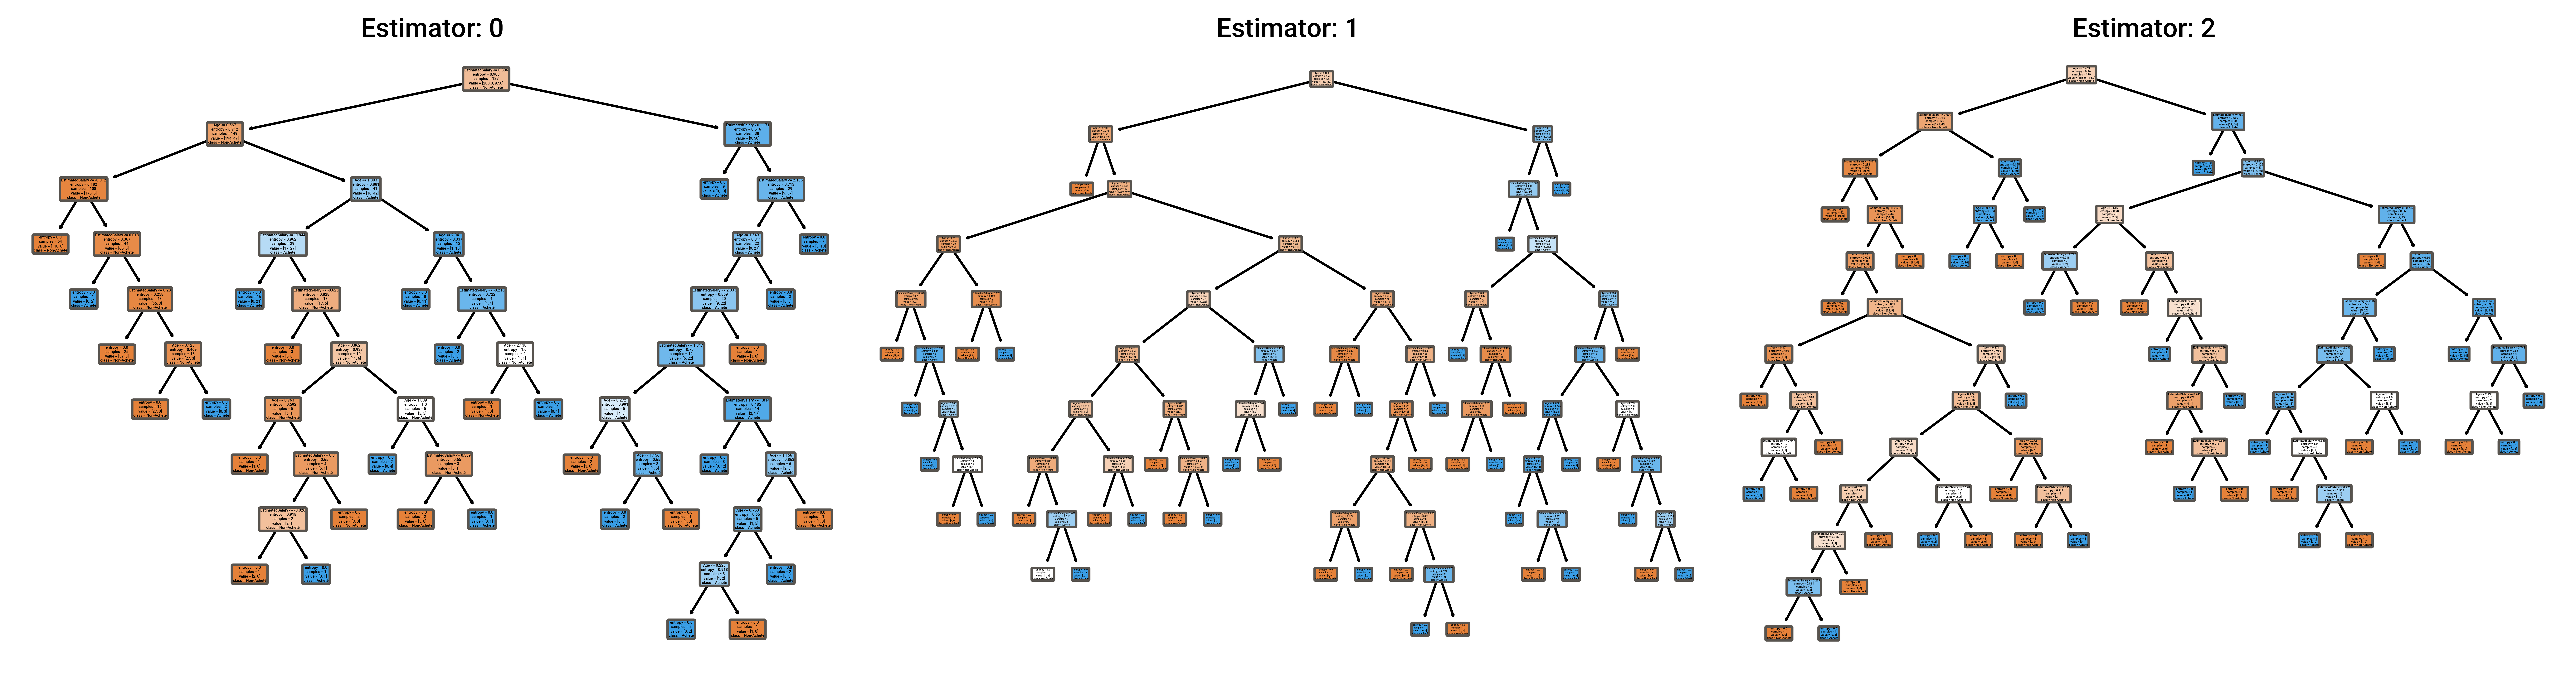

In [299]:
n = 3
fig, axes = plt.subplots(1, n, figsize=(15, 4), dpi=900)
for ind in range(0, n):
    plot_tree(rfc.estimators_[ind], feature_names=X_train[cols].columns, ax=axes[ind],
              class_names=['Non-Acheté', 'Acheté'], filled=True, rounded=True)
    axes[ind].set_title('Estimator: ' + str(ind), fontsize = 11)
plt.tight_layout()
plt.show()

## 3. Boosting

In [300]:
gbc = GradientBoostingClassifier(n_estimators=5)
gbc.fit(X_train, y_train)
gbc.score(X_test, y_test)

0.87

In [301]:
abc = AdaBoostClassifier(n_estimators=5)

abc.fit(X_train, y_train)
abc.score(X_test, y_test)

0.91

## 4. Stacking

In [302]:
model1 = SGDClassifier(random_state=0)
model2 = DecisionTreeClassifier(random_state=0)
model3 = KNeighborsClassifier(n_neighbors=2)

model = StackingClassifier([('SGD', model1),
                           ('Tree', model2),
                           ('KNN', model3)],
                          final_estimator=KNeighborsClassifier())

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.88